### Attention Based Machine Translation

In this note I will build an attention-based LSTM Seq2Seq model for English to Chinese Translation. The details of the Luong Attention model can be found in this paper: [Efective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf), and dot score is being used for the calculation of alignment weight vector. I will explain the construction of attention layer using visualization.

The Chinese-English dataset can be downloaded at http://www.manythings.org/anki/. <br>

### Prepare dataset
- Add a start of sentence `<sos>` and end of sentence `<eos>` token to each sentence.
- Clean the sentences by removing special characters.
- Create a word index and reverse word index
- Pad each sentence to a maximum length.

In [0]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
def preprocess_en_sentence(w):
  w = w.lower()

  # Add a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy . " => "he is a boy ."
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'\s{2,}', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
  w = w.strip()
  return w

def preprocess_cn_sentence(w):
  # Remove special punctuations
  w = re.sub(r'[“”()]', '', w)

  # Add empty spaces between words
  w = ' '.join([char for char in w])

  # Add a start and an end token to the sentence
  w = '<sos> ' + w + ' <eos>'
  return w

In [15]:
print(preprocess_en_sentence('Hi! How can I help you?'))
print()
print(preprocess_cn_sentence('你好！我可以帮什么忙吗？'))

hi ! how can i help you ?

<sos> 你 好 ！ 我 可 以 帮 什 么 忙 吗 ？ <eos>


In [0]:
num_examples = 17000
en_sentences = []
cn_sentences = []

with open('cmn.txt', 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
  for line in lines[:min(len(lines)-1, num_examples)]:
      en_sentence, cn_sentence, _ = line.split('\t')
      en_sentences.append(preprocess_en_sentence(en_sentence))
      cn_sentences.append(preprocess_cn_sentence(cn_sentence))

In [17]:
print(en_sentences[-1])
print(cn_sentences[-1])

what i want is some peace and quiet .
<sos> 我 所 想 要 的 是 一 点 平 和 和 安 静 。 <eos>


In [0]:
def tokenize(texts):
  tokenizer = Tokenizer(filters='')
  tokenizer.fit_on_texts(texts)
  tensor = tokenizer.texts_to_sequences(texts)
  tensor = pad_sequences(tensor, padding='post')
  return tensor, tokenizer

In [0]:
encoder_tensor, encoder_tokenizer = tokenize(en_sentences)
decoder_tensor, decoder_tokenizer = tokenize(cn_sentences)

# Calculate max_length of the encoder and decoder tensors
max_len_encoder = encoder_tensor.shape[1]
max_len_decoder = decoder_tensor.shape[1]

# Calculate number of unique tokens for the encoder and decoder
num_words_encoder = len(encoder_tokenizer.word_index) + 1
num_words_decoder = len(decoder_tokenizer.word_index) + 1

In [20]:
print(encoder_tensor.shape)
print(decoder_tensor.shape)

(17000, 12)
(17000, 25)


### Encoder and Decoder model

In [0]:
hidden_units = 1024
embedding_dim = 256

#### Encoder


In [0]:
encoder_inputs = keras.Input(shape=(max_len_encoder,))
encoder_embedding = Embedding(num_words_encoder, 
                              embedding_dim, 
                              mask_zero=True,
                              input_length=max_len_encoder)(encoder_inputs)
encoder_outputs, encoder_state_h, encoder_state_c = LSTM(
    hidden_units, return_state=True, 
    return_sequences=True, unroll=True)(encoder_embedding)
encoder_states = [encoder_state_h, encoder_state_c]

There are two internal states in LSTM, the **hidden state**, usually denoted by **h**, and the **cell state** usually denoted by **c**. The tuple **(c, h)** is the **internal state** of a LSTM. The hidden state h is output for every timestep the LSTM is unrolled. 

LSTM with `return_sequences=True` returns the hidden state of the LSTM for every timestep in the input to the LSTM. 

For example, if the input batch is (samples, timesteps, dims), then the call `LSTM(units, return_sequences=True)` will generate output of dimensions (samples, timesteps, units).

However, if you also want the final internal cell state of LSTM, use `LSTM(units, return_sequence=True, return_state=True)` instead. <br><br>

<img src='https://drive.google.com/uc?id=1uyRKZZ2gl1iSFO65Oq-XY8abTCiXlGNO'></img>


In [23]:
print('encoder_outputs: ', encoder_outputs)
print('encoder_state_h: ', encoder_state_h)
print('encoder_state_c: ', encoder_state_c)

encoder_outputs:  Tensor("lstm/Identity:0", shape=(None, 12, 1024), dtype=float32)
encoder_state_h:  Tensor("lstm/Identity_1:0", shape=(None, 1024), dtype=float32)
encoder_state_c:  Tensor("lstm/Identity_2:0", shape=(None, 1024), dtype=float32)


#### Decoder

In [0]:
decoder_inputs = keras.Input(shape=(max_len_decoder,))
decoder_embedding = Embedding(num_words_decoder, 
                           embedding_dim, 
                           input_length=max_len_decoder)(decoder_inputs)
decoder_outputs, decoder_state_h, decoder_state_c = LSTM(
    hidden_units, return_sequences=True, return_state=True)(
        decoder_embedding, initial_state=encoder_states)

In [25]:
print('decoder_outputs: ', decoder_outputs)
print('decoder_state_h: ', decoder_state_h)
print('decoder_state_c: ', decoder_state_c)

decoder_outputs:  Tensor("lstm_1/Identity:0", shape=(None, 25, 1024), dtype=float32)
decoder_state_h:  Tensor("lstm_1/Identity_1:0", shape=(None, 1024), dtype=float32)
decoder_state_c:  Tensor("lstm_1/Identity_2:0", shape=(None, 1024), dtype=float32)


#### Attention Layer 

This Attention model is based on the paper: [Efective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf).

Alignment weight vector $\alpha_t$ based on the current target hidden state $h_t$ and all sources states $\bar{h}_s$. <br><br>


$$\alpha_t(s) = align(h_t, \bar{h_s})=\frac{exp(score(h_t, \bar{h_s}))}{\sum_{s^{'}}exp(score(h_t, \bar{h_{s^{'}}}))}$$

<br>
Where

$$h_t : \text{current target hidden state}$$
<br>
$$\bar{h}_s :  \text{source hidden state}$$
<br>

We applied dot score here:<br>

$$score(h_t, \bar{h_s}) = h_t^T\bar{h_s}$$

<br>

Documentation for **Dot** layer: https://keras.io/api/layers/merging_layers/dot/

> Layer that computes a dot product between samples in two tensors. 


In [0]:
from tensorflow.keras.layers import (Dot, Activation, 
                                     concatenate, 
                                     TimeDistributed)

In [27]:
# Attention Layer
attention = Dot(axes=2)([decoder_outputs, encoder_outputs])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

attention Tensor("attention/Identity:0", shape=(None, 25, 12), dtype=float32)


This process is illustrated below: <br><br>
<img src='https://drive.google.com/uc?id=1--xGolyVK-UWkv6S17GM17mMGsbElGHV'></img>


A **context vector** $c_t$ is then computed as the weighted average of all source states, according to the alignment weight $\alpha_t$.

In [28]:
context = Dot(axes=[2, 1])([attention, encoder_outputs])
print('context', context)

context Tensor("dot_1/Identity:0", shape=(None, 25, 1024), dtype=float32)


This process is illustrated below: <br><br>
<img src='https://drive.google.com/uc?id=1bIGg3_wl3wqYLBGEgx56heKRNSNn-DWc' width=1000></img>


Then given the target hidden state $h_t$ and
the source-side context vector $c_t$, we employ a
simple concatenation layer to combine the information from both vectors to produce an attentional
hidden state:

$$[c_t; h_t]$$

In [127]:
decoder_combined_context = concatenate([context, decoder_outputs])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate_1/Identity:0", shape=(None, 25, 2048), dtype=float32)


<img src='https://drive.google.com/uc?id=1ZcyT28CbhhLRAQ7-SCnjOBF85dix9qay' width=1000></img>


Then we will produce an **attentional hidden state** $\tilde{h}_t$ as follows: <br> <br>

$$\tilde{h}_t = tanh(W_c[c_t;h_t])$$

<br>

This attentional hidden state will then be fed through the **softmax layer** to produce the predictive distribution. <br> <br>

$$p(y_t|y_{<t}, x) = softmax(W_s \tilde{h}_t)$$

Documentatin of **TimeDistributed** Layer: https://keras.io/api/layers/recurrent_layers/time_distributed/

>This wrapper allows to apply a layer to every temporal slice of an input. The input should be at least 3D, and the dimension of index one will be considered to be the temporal dimension.
>
>For example, consider a batch of 32 video samples, where each sample is a 128x128 RGB image with channels_last data format, across 10 timesteps. The batch input shape is (32, 10, 128, 128, 3).

In [30]:
output = TimeDistributed(Dense(hidden_units, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(num_words_decoder, activation="softmax"))(output)
print('output', output)

output Tensor("time_distributed_1/Identity:0", shape=(None, 25, 3040), dtype=float32)


<img src='https://drive.google.com/uc?id=1lWueNI_nNByU7_lQqCvroMaHafxE3C8W' width=1000></img>

#### The Whole Model

In [0]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

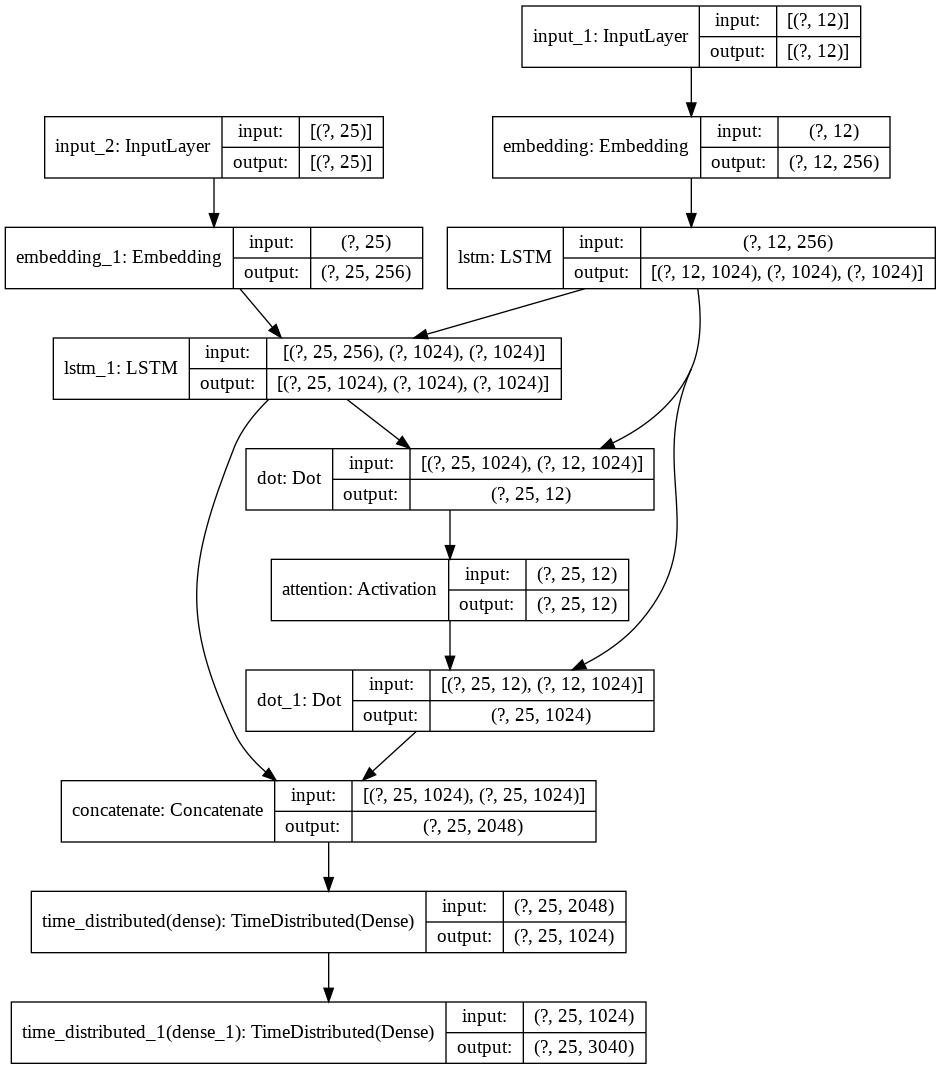

In [32]:
tf.keras.utils.plot_model(model, to_file='my_model.png', show_shapes=True)

#### Model Training

In [0]:
encoder_input = encoder_tensor.copy()

decoder_input = np.zeros_like(decoder_tensor)
decoder_input[:, 1:] = decoder_tensor[:,:-1]  # The last one is not included
decoder_input[:, 0] = decoder_tokenizer.word_index['<sos>']

# decoder_output is the same as decoder_input but offset by one timestep.
decoder_output =np.zeros_like(decoder_tensor)
decoder_output[:, :-1] = decoder_tensor[:,1:]  # The first one is not included
decoder_output = np.eye(num_words_decoder)[decoder_output.astype('int')]

In [84]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_output.shape)

(17000, 12)
(17000, 25)
(17000, 25, 3040)


In [0]:
my_callbacks = [EarlyStopping(patience=3)]

In [86]:
BATCH_SIZE = 16
EPOCHS = 10
model.fit([encoder_input, decoder_input], 
           decoder_output,
           batch_size=BATCH_SIZE,
           epochs=EPOCHS,
           callbacks=my_callbacks,
           validation_split=0.2)

Epoch 1/10
850/850 [==============================] - 830s 977ms/step - loss: 1.0094 - accuracy: 0.8112 - val_loss: 1.8427 - val_accuracy: 0.6941
Epoch 2/10
850/850 [==============================] - 830s 976ms/step - loss: 0.8721 - accuracy: 0.8331 - val_loss: 1.8417 - val_accuracy: 0.6998
Epoch 3/10
850/850 [==============================] - 846s 995ms/step - loss: 0.7285 - accuracy: 0.8585 - val_loss: 1.8453 - val_accuracy: 0.7014
Epoch 4/10
850/850 [==============================] - 836s 984ms/step - loss: 0.5986 - accuracy: 0.8840 - val_loss: 1.8776 - val_accuracy: 0.7036
Epoch 5/10
850/850 [==============================] - 840s 988ms/step - loss: 0.4976 - accuracy: 0.9068 - val_loss: 1.8987 - val_accuracy: 0.7046


In [0]:
model.save('seq2seq_attention_model.h5')
# from google.colab import files
# files.download('seq2seq_attention_model.h5')
# from keras.models import load_model
# model = load_model('seq2seq_attention_model.h5')

<img src='https://drive.google.com/uc?id=1DbDSjuv2a5-XVgXaVg6bRijJ-69Dj-7y' width=800></img>

Note the `decoder input` at time step `t` is the `decoder output` at time step `t-1`.

In [0]:
def predict(text):
  text = preprocess_en_sentence(text)
  encoder_input = pad_sequences(encoder_tokenizer.texts_to_sequences([text]), 
                                maxlen=max_len_encoder, padding='post')
  decoder_input = np.zeros(shape=(len(encoder_input), max_len_decoder))
  decoder_input[:,0] = decoder_tokenizer.word_index['<sos>']
  for i in range(1, max_len_decoder):
      output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
      decoder_input[:,i] = int(output[:,i-1])
  return decoder_input[:, 1:][0]

def decode(index_sequence):
  text = ''
  for index in index_sequence:
      if index == 0:
         text = text 
      elif index == decoder_tokenizer.word_index['<eos>']:
         break
      else:
         text += decoder_tokenizer.index_word[index]
  return text

In [114]:
print(decode(predict(text='How is your day?')))
print(decode(predict(text='I like you!')))
print(decode(predict(text='I want to eat dinner!')))

你天怎样？
我喜你
我想吃饭饭饭？


### Visualize Attention Layer

In [90]:
attention_layer = model.get_layer('attention') 
attention_model = keras.Model(inputs=model.inputs, 
                              outputs=model.outputs + [attention_layer.output])
print(attention_model)
print(attention_model.output_shape)

[(None, 25, 3040), (None, 25, 12)]


In [0]:
# Use external font for chinese character
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/chinese.stsong.ttf'
fontprop = fm.FontProperties(fname=path, size=14)

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
def attent_and_generate(text):
    text = preprocess_en_sentence(text)
    encoder_input = pad_sequences(encoder_tokenizer.texts_to_sequences([text]), 
                                  maxlen=max_len_encoder, padding='post')
    decoder_input = np.zeros(shape=(len(encoder_input), max_len_decoder))
    decoder_input[:,0] = decoder_tokenizer.word_index['<sos>']
    
    for i in range(1, max_len_decoder):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i-1]
        attention_density = attention[0]
        decoded_output = decode(decoder_input[0][1:])
        
    return text, attention_density, decoded_output

def visualize(text):
    text, attention_density, chinese = attent_and_generate(text)
    xticklabels = [w for w in text.split()]
    yticklabels = [w for w in chinese]

    plt.clf()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(attention_density[:len(chinese), :len(text.split())], 
                     cmap='viridis')
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels, fontproperties=fontprop)
    ax.invert_yaxis()
    plt.show()

<Figure size 432x288 with 0 Axes>

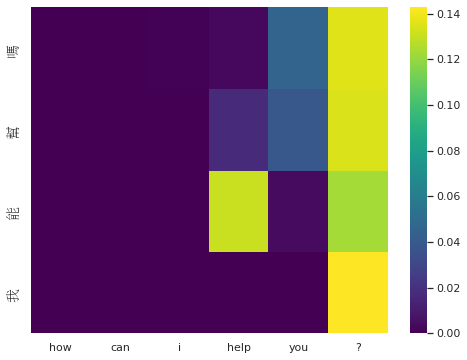

In [126]:
txt = 'How can I help you?'
visualize(txt)
plt.show()